In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import joblib

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, LSTM, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [ ]:
SEQ_LENGTH = 5
data = './Dataset.csv'

df = pd.read_csv(data)
df.columns = df.columns.str.strip()
df.dropna()

# Keep only relevant columns
base_features = ["rpm", "speedX", "speedY", "speedZ", "trackPos", "z", 
                 "steer", "accel", "brake"]
track_features = [f"track_{i}" for i in range(0, 19)]  # track_1 to track_19

df = df[base_features + track_features].copy()

# Engineered inputs
df['speed'] = np.sqrt(df['speedX']**2 + df['speedY']**2 + df['speedZ']**2)
df['trackWidth'] = df['track_1'] + df['track_2']
df['upcomingCurvature'] = df[['track_3', 'track_4', 'track_5']].mean(axis=1)
df['distanceFromCenter'] = np.abs(df['trackPos'])
df['trackPosSquared'] = df['trackPos'] ** 2

# Select features for X (30 total features)
X_columns = ['rpm', 'speedX', 'speedY', 'speedZ', "trackPos", "z", 'speed', 'trackWidth', 'upcomingCurvature', 
             'distanceFromCenter', 'trackPosSquared'] + track_features
Y_columns = ['steer', 'accel', 'brake']

# Ensure length matches
assert len(X_columns) == 30, f"Expected 30 features, got {len(X_columns)}"

# Scale inputs
# robust scaler is more beautiful at handling outliers
scaler = RobustScaler()
scaled_features = ['rpm', 'speedX', 'speed', 'trackWidth', 'upcomingCurvature', 
                'distanceFromCenter', 'trackPosSquared']
df[scaled_features] = scaler.fit_transform(df[scaled_features])
joblib.dump(scaler, "racing_scaler.pkl")

X_data = df[X_columns].values
Y_data = df[Y_columns].values
Y_data[:, 0] = np.clip(Y_data[:, 0], -1.0, 1.0)  # steer
Y_data[:, 1] = np.clip(Y_data[:, 1], 0.0, 1.0)   # accel
Y_data[:, 2] = np.clip(Y_data[:, 2], 0.0, 1.0)   # brake

# Create sequences
X_sequences, Y_sequences = [], []
for i in range(len(df) - SEQ_LENGTH):
    X_sequences.append(X_data[i:i+SEQ_LENGTH])
    Y_sequences.append(Y_data[i+SEQ_LENGTH])

X_sequences = np.array(X_sequences)
Y_sequences = np.array(Y_sequences)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_sequences, Y_sequences, test_size=0.2, random_state=42)

print("DF Columns: ", df.columns)
print("Input shape:", X_train.shape)  # Should be (num_samples, 5, 30)
print("Output Shape: ", Y_train.shape)


DF Columns:  Index(['rpm', 'speedX', 'speedY', 'speedZ', 'trackPos', 'z', 'steer', 'accel',
       'brake', 'track_0', 'track_1', 'track_2', 'track_3', 'track_4',
       'track_5', 'track_6', 'track_7', 'track_8', 'track_9', 'track_10',
       'track_11', 'track_12', 'track_13', 'track_14', 'track_15', 'track_16',
       'track_17', 'track_18', 'speed', 'trackWidth', 'upcomingCurvature',
       'distanceFromCenter', 'trackPosSquared'],
      dtype='object')
Input shape: (247838, 5, 30)
Output Shape:  (247838, 3)


In [ ]:
DATA_DIR = "./"
SEQ_LENGTH = 5
BATCH_SIZE = 64
EPOCHS = 500
PATIENCE = 10

In [ ]:
# LSTM model architecture
input_shape = (SEQ_LENGTH, X_train.shape[2])  # (time steps, features ka count)

# Input layer
inputs = tf.keras.Input(shape = (X_train.shape[1], X_train.shape[2]))

# LSTM layers ayyy
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64)(x)

# Dense layers with dropout for regularization
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# Outpit Layer
outputs = tf.keras.layers.Dense(3)(x)

# Model with multiple outputs ---> humara multi-output regression model
model = Model(inputs=inputs, outputs=outputs)

learning_rate = 1e-3  # Slightly lower learning rate for LSTM
model.compile(
    optimizer = Adam(learning_rate=1e-3), 
    loss='mse', 
    metrics=['mae']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Fit model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=BATCH_SIZE,  # Smaller batch size for more stable LSTM training
    epochs=EPOCHS,
    shuffle=True,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/500
727/727 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - acceleration_loss: 0.0683 - acceleration_mae: 0.1823 - braking_loss: 0.0221 - braking_mae: 0.0762 - loss: 0.1473 - steering_loss: 0.0569 - steering_mae: 0.1415 - val_acceleration_loss: 0.0367 - val_acceleration_mae: 0.1095 - val_braking_loss: 0.0101 - val_braking_mae: 0.0323 - val_loss: 0.0557 - val_steering_loss: 0.0087 - val_steering_mae: 0.0476 - learning_rate: 0.0010
Epoch 2/500
727/727 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - acceleration_loss: 0.0378 - acceleration_mae: 0.1141 - braking_loss: 0.0107 - braking_mae: 0.0349 - loss: 0.0584 - steering_loss: 0.0099 - steering_mae: 0.0577 - val_acceleration_loss: 0.0330 - val_acceleration_mae: 0.0956 - val_braking_loss: 0.0091 - val_braking_mae: 0.0274 - val_loss: 0.0502 - val_steering_loss: 0.0079 - val_steering_mae: 0.0486 - learning_rate: 0.0010
Epoch 3/500
727/727 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - acceleration_loss: 0.0337 - acceleration_mae: 0.1032 - braking_loss: 0.0095 - bra

In [ ]:
# Save model
model.save('torcs_model.h5')
model.save_weights('lstm_model_weights.weights.h5')

# Model summary show karo
model.summary()

# also save tflite - tensorflow lite file
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

try:
    tflite_model = converter.convert()
    with open("torcs_model.tflite", 'wb') as f:
        f.write(tflite_model)

    print("TFLite model has been saved successfully!")

except Exception as e:
    print(f"Error converting the model to TFLite: {e}")
    model.save("torcs_model_saved", save_format='tf')

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5, 28)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 5, 128)    │     80,384 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ lstm_20[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ lstm_21[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ acceleration        │ (None, 1)         │         33 │ dense_21[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ braking (Dense)     │ (None, 1)         │         33 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steering (Dense)    │ (None, 1)         │         33 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 409,547 (1.56 MB)

 Trainable params: 136,515 (533.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 273,032 (1.04 MB)

Example prediction - Accel: 0.4626, Brake: 0.0007, Steer: 0.0591


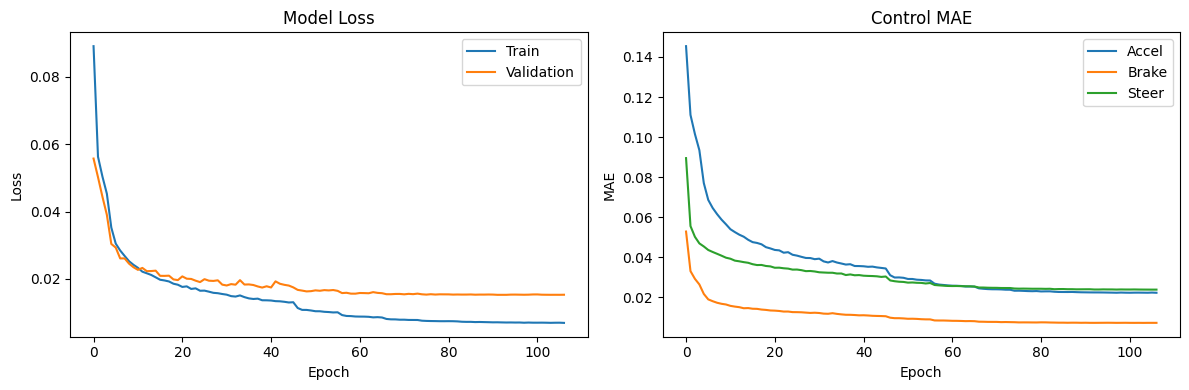

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
# Updated history keys for metrics
plt.plot(history.history['acceleration_mae'])
plt.plot(history.history['braking_mae'])
plt.plot(history.history['steering_mae'])
plt.title('Control MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Accel', 'Brake', 'Steer'], loc='upper right')
plt.tight_layout()
plt.savefig('lstm_training_history.png')

# Test prediction function
def predict_control(sequence):
    """
    Make a prediction using a sequence of observations
    
    Parameters:
    sequence: numpy array of shape (SEQ_LENGTH, n_features)
    
    Returns:
    Tuple of (acceleration, brake, steering) predictions
    """
    # Reshape to (1, SEQ_LENGTH, n_features) for single prediction
    sequence = sequence.reshape(1, SEQ_LENGTH, -1)
    
    # Make prediction
    accel_pred, brake_pred, steer_pred = model.predict(sequence, verbose=0)
    
    return accel_pred[0][0], brake_pred[0][0], steer_pred[0][0]

# Example prediction
if len(X_test) > 0:
    test_seq = X_test[0]
    accel, brake, steer = predict_control(test_seq)
    print(f"Example prediction - Accel: {accel:.4f}, Brake: {brake:.4f}, Steer: {steer:.4f}")